# How to use **ddCRP**:  An example with synthetic data

This notebook is analogous to the documentation contained in the ReadMe.md file.  We begin by importing the necessary modules.  *ddCRP* contains the actual modeling algorithm, *Priors* contains the allowed prior models (Normal-Inverse-Chi-Squared and Normal-Inverse-Wishart), and *synthetic* contains methods for sampling synthetic data.

In [41]:
from ddCRP import ddCRP
from ddCRP import Priors
from ddCRP import synthetic

import numpy as np

Next, we define some parameters for generating our synthetic data.  In this case, we are sampling our synthetic data from a *Normal-Inverse-Chi-Squared* model:

$$
(\mu,\sigma) \sim NI \chi^{2} (\mu_{0},\kappa_{0}; \nu_{0},\sigma^{2}_{0})
$$

where $\mu_{0}$ and $\kappa_{0}$ are priors on the feature means, while $\nu_{0}$ and $\sigma^{2}_{0}$ are priors on the feature variance.

Here, for each unique label in our synthetic data, we sample $d$ unique means and variances, and then sample feature vectors from a multivariate normal distribution with independent features (a.k.a. diagonal covariance matrix, and hence the Normal-Inverse-Chi-Squared model).

We could just as easily skip the Normal-Inverse-Chi-Squared aspect, and simply define a set of multivariate Normal distributions.  However, in this way, we can see how hyperparameter tuning of our ddCRP model relates to the hyperparameters of our synthetic data model.

In [3]:
# dimensionality of data
d = 5

mu = 0
kappa = 0.0001
nu = 9
sigma=1

Next, we initialize a **SampleSynthetic** object. ```kind=ell``` defines what type of synthetic data we are modeling.  Options for this parmeter include ```['ell', 'stripes', 'face', 'square']```.

In [9]:
synth = synthetic.SampleSynthetic(kind='ell', d=d, mu0=0, kappa0=kappa, nu0=nu, sigma0=sigma)
synth.fit()

print('Attributes of synth: \n')
print(list(synth.__dict__.keys()))

Attributes of synth: 

['kind', 'd', 'mu0', 'kappa0', 'nu0', 'sigma0', 'z_', 'adj_list_', 'parcels_', 'params_', 'parcel_features_', 'features_']


We're specifically interested in ```z_```, ```adj_list_```, and ```features_```.  ```z_``` represents the ground truth label map of our synthetic data, ```adj_list_``` is the adjancey list of our samples, and ```features_``` are the multivariate feature vectors of our data.

Next, we initialize our prior model.  In this case, we'll use the **Normal-Inverse-Wishart** prior.  We need to define a multivariate mean vector prior $\bar{\mu_{0}}$, and a prior on the covariance matrix $\bar{\lambda_{0}}$ (for the inverse-Wishart distribution), along with $\kappa_{0}$ and $\nu_{0}$ as above.

In [12]:
mu_bar = np.zeros((d,))
lambda_bar = np.random.rand(d,d) + np.eye(d)

niw = Priors.NIW(mu0=mu_bar,kappa0=kappa,nu0=nu,lambda0=lambda_bar)

Finally, we can initialize our ddCRP model.  We first need to define a "concentration parameter", $\alpha$, that determines how likely points are to create new clusters or join an existing cluster.  We also provide some arguments that govern how many MCMC iterations we want to perform, and how often we want to sample and print out diagnostic information regarding the current state of our model.

In [15]:
alpha = 10

crp = ddCRP.ddCRP(alpha, model=niw, mcmc_passes=30, stats_interval=200)
crp.fit(synth.features_, synth.adj_list_, gt_z=synth.z_)

Step: 0 Time: -1535423038.983277 LP: -1428.235933442534 K: 86 MaxLP: -1428.235933442534
Step: 200 Time: -1535423037.84502 LP: 79.05664565469496 K: 39 MaxLP: 79.05664565469496
Step: 400 Time: -1535423036.7848172 LP: 1164.2113205899 K: 13 MaxLP: 1164.2113205899
Step: 600 Time: -1535423035.720298 LP: 1531.7110938022763 K: 11 MaxLP: 1531.7110938022763
Step: 800 Time: -1535423034.6766562 LP: 1680.7664135860002 K: 9 MaxLP: 1680.9237756908226
Step: 1000 Time: -1535423033.644149 LP: 1721.1835505349457 K: 8 MaxLP: 1721.1835505349457
Step: 1200 Time: -1535423032.5858352 LP: 1753.5485264093254 K: 7 MaxLP: 1753.5485264093254
Step: 1400 Time: -1535423031.534706 LP: 1826.1528084516692 K: 6 MaxLP: 1826.1528084516692
Step: 1600 Time: -1535423030.5029182 LP: 1840.3702242881873 K: 6 MaxLP: 1840.3702242881873
Step: 1800 Time: -1535423029.4654272 LP: 1857.43741472072 K: 6 MaxLP: 1857.43741472072
Step: 2000 Time: -1535423028.4108891 LP: 1962.3833731598952 K: 7 MaxLP: 1964.6859582528896
Step: 2200 Time: -15

Now we can print out the our ground truth label map, the *maximum-a-posterior* label map (i.e. the label configuration that maximizes the marginal evidence of our feature data, and the intial (essentially random) map that the ddCRP model starts out with.  The actual label values (colors) are arbitrary, and don't convey any special meaning.

Below the images are plots showing the number of clusters, marginal-evidence, and current *MAP*-evidence, each as a function of MCMC iterations (the sampling frequency is determined by the ```stats_interval``` parameter in the ddCRP model instantiation).

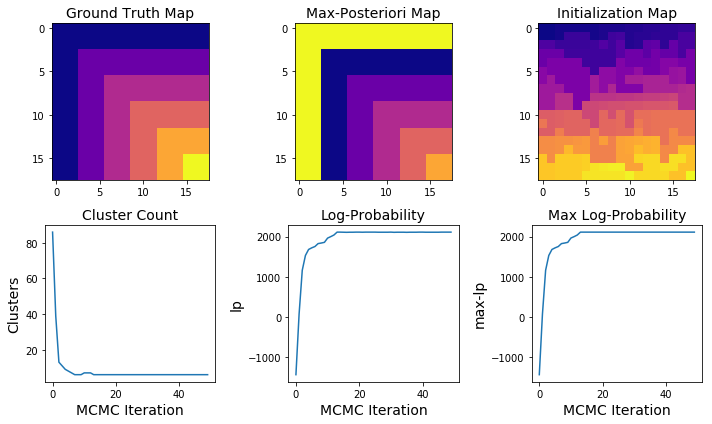

In [40]:
plot = synthetic.plot_synthetic(synth, crp, figsize=(10,6), cmap='plasma');
plot